---
highlight-style:
  light: arrow.theme
  dark: arrow-dark.theme
format:
  html:
    code-line-numbers: false
    code-overflow: wrap
---



# Linear Programming {#sec-linear}

In this chapter, we first go through the modeling capabilities provided by Google OR-Tools to solve linear programming problems.
Then we get our hands dirty by solving some linear programming problems.

## Modeling Capabilities

There are three components in a mathematical model, namely, decision varaibles, constraints and objective, for which we will go over in the following sections.

### Solver

In Google OR-Tools, a `Solver` instance must be created first so that variables, constraints and objective can be added to it.
The `Solver` class is defined in the `ortools.linear_solver.pywraplp` module and it requires a solver id to instantiate an object.
In the code snippet below, the required module is imported first and a `solver` object is created with `GLOP`, Google's own optimization engine for solving linear programming problems.
It is good practice to verify whether the desired solver is indeed created successfully or not.

In [63]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver("GLOP")

if solver:
    print("solver creation success!")
else:
    print("solver creation failure!")

solver creation success!


### Decision Variables

The `Solver` class defines a number of ways to create decision variables:

1. `Var(lb, ub, integer, name)`
2. `NumVar(lb, ub, name)`
3. `IntVar(lb, ub, name)`
4. `BoolVar(name)`

- Function `Var()`

The `Var()` method is the most flexible way to define variables, as it can be used to create numerical, integral and boolean variables.
In the following code, a numerical variable named 'var1' is created with bound (0.0, 1.0).
Note that the parameter `integer` is set to `False` in the call to function `Var()`.

In [64]:
var1 = solver.Var(lb=0, ub=1.0, integer=False, name="var1")

We could create an integer variable using the same function:

In [65]:
var2 = solver.Var(lb=0, ub=1.0, integer=True, name="var2")

- Function `NumVar()`

`var1` could be creatd alternatively using the specialized function `NumVar()`:

In [66]:
var1 = solver.NumVar(lb=0, ub=1.0, name="var1")

- Function `IntVar()`

Similarly, `var2` could be created alternatively using the specialized function `IntVar()`:

In [67]:
var2 = solver.IntVar(lb=0, ub=1.0, name="var2")

- Function `BoolVar()`

A boolean variable could be created using the `BoolVar()` function:

In [68]:
var3 = solver.BoolVar(name="var3")

### Constraints

Constraints limit the solution space of an optimization problem, and there are two ways to define constraints in Google OR-Tools.
In the first approach, we could use the `Add()` function to create a constraint and automatically add it to the model at the same time, as the below code snippet illustrates.

In [69]:
cons1 = solver.Add(constraint=var1 + var2 <= 1, name="cons1")

type(cons1)

ortools.linear_solver.pywraplp.Constraint

Note that the `Add()` function returns an object of the `Constraint` class defined in the `pywraplp` module, as shown in the code output.
It is a good practice to retain the reference of the newly created constraint, as we might want to query its information later on.

The second approach works in a slightly different way. It starts with an empty constraint, with potential lower bound and upper bounds provided, and add components of the constraint gradually.
The code snippet below shows an example of adding a second constraint to the model.
In this approach, we must retain the reference to the constraint, as it is needed to add decision variables to the constraint in following steps.

In [70]:
cons2 = solver.Constraint(-solver.infinity(), 10.0, "cons2")
cons2.SetCoefficient(var1, 2)
cons2.SetCoefficient(var2, 3)
cons2.SetCoefficient(var3, 4)
type(cons2)

ortools.linear_solver.pywraplp.Constraint

### Objective

Similar to constraints, there are two ways to define the objective in Google OR-Tools.
In the first approach, we directly add an objective to the model by using the `Maximize()` or `Minimize()` function.
Below is an example:



In [71]:
solver.Minimize(var1 + var2 + var3)

Note that the function itself does not return a reference to the newly created objective function, but we could use a dedicated function to retrive it:

In [72]:
obj = solver.Objective()
print(obj)

<ortools.linear_solver.pywraplp.Objective; proxy of <Swig Object of type 'operations_research::MPObjective *' at 0x10f1e92c0> >


In the second approach, we build the objective incrementally, just as in the second approach of creating constraints.
Specifically, we start with an empty objective function, and gradually add components to it.
In the end, we specify the optimization sense - whether we want to maximize or minimnize the objective.

In [73]:
obj = solver.Objective()
obj.SetCoefficient(var1, 1.0)
obj.SetCoefficient(var2, 1.0)
obj.SetCoefficient(var3, 1.0)
obj.SetMinimization()
print(obj)

<ortools.linear_solver.pywraplp.Objective; proxy of <Swig Object of type 'operations_research::MPObjective *' at 0x10fc86670> >


### Objective and Constraint Expressions

When we build constraints or objective functions, sometimes they comprise of complex expressions that we would like to build incrementally, possibly within loops.
For example, we might have a mathematical expression of the form $expr = 2x_1 + 3x_2 + 4x_3 + x_4$, which could be part of the objective function or any constraints.
In this case, we can either use the aforementioned `SetCoefficient()` function to add each element of the expression to the constraint or objective, or we could build an expression first and add it once in the end.
The code snippet below shows an example.

In [74]:
infinity = solver.Infinity()
x1 = solver.NumVar(0, infinity, name="x1")
x2 = solver.NumVar(0, infinity, name="x2")
x3 = solver.NumVar(0, infinity, name="x3")
x4 = solver.NumVar(0, infinity, name="x4")

expr = []
expr.append(2 * x1)
expr.append(3 * x2)
expr.append(4 * x3)
expr.append(x4)

constr = solver.Add(solver.Sum(expr) <= 10)
print(constr)

solver.Minimize(solver.Sum(expr))

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x10fcb3060> >


Of course, it is not obvious here that the retitive calls to the `append()` method are any more convenient than the `SetCoefficient()` method.
Let's say that we have a slightly more complex expression of the form $\sum_{0 \le i < 4}w_i \cdot x_i$, now we could build the expression using a loop:

In [75]:
w = [2, 3, 4, 1]
x = [x1, x2, x3, x4]
expr = []
for i in range(4):
    expr.append(w[i] * x[i])

constr = solver.Add(solver.Sum(expr) <= 10)

### Query the Model

After we build the model, we can query it using some helper functions.
For example, to get the total number of constraints, we use the `NumVariables()` function.
In a similar fashion, we can retrieve the total number of constraints with the `NumConstraints()` function.

In [76]:
num_vars = solver.NumVariables()
print(f"there are a total of {num_vars} variables in the model")

num_constr = solver.NumConstraints()
print(f"there are a total of {num_constr} constraints in the model")

there are a total of 9 variables in the model
there are a total of 4 constraints in the model


## Applications

In this section, we use some examples to showcase the modeling capability of Google OR-Tools.

### Trivial Problem

We now consider an simple linear programming problem with two decision variables $x$ and $y$.
The formal mathematical model is defined as below:


\begin{align}
\text{max.} \quad & x + 2y \\
\text{s.t.} \quad & x + y \le 10 \\
& x >= 1 \\
& y >= 1
\end{align}


@fig-lp-example shows the three defining constraints represented in blue lines and the feasible space depicted by the orange shaded area.
The objective function is indicated by the red dashed lines.
It can be seen from the figure that the point in green circle gives the maximal objective value of 19.

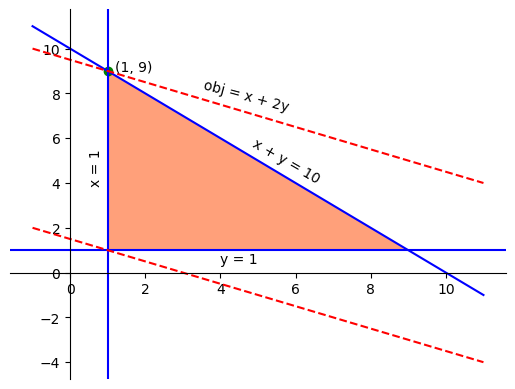

In [77]:
# | echo: false
# | fig-cap: A simple LP example
# | label: fig-lp-example
import matplotlib.pyplot as plt
import numpy as np

# setup axis
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines["left"].set_position("zero")
ax.spines["bottom"].set_position("zero")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

# plot three constraints
x = np.linspace(-1, 11)
y = 10 - x
plt.plot(x, y, "b")
plt.axvline(x=1, color="b")
plt.axhline(y=1, color="b")

# add annotations
ax.annotate("y = 1", xy=(4, 0.4))
ax.annotate("x = 1", xy=(0.5, 4), rotation=90)
ax.annotate("x + y = 10", xy=(4.8, 4), rotation=-30)

# show the feasible space
corners_x = np.array([1, 9, 1])
corners_y = np.array([1, 1, 9])
plt.fill(corners_x, corners_y, facecolor="lightsalmon")

# add objective function
obj_x = np.linspace(-1, 11)
obj_y = 9.5 - 0.5 * obj_x
plt.plot(obj_x, obj_y, "r--")
ax.annotate("obj = x + 2y", xy=(3.5, 7.2), rotation=-15)
ax.annotate("(1, 9)", xy=(1.2, 9))
plt.scatter(1, 9, marker="o", c="g")


obj_x = np.linspace(-1, 11)
obj_y = 1.5 - 0.5 * obj_x
plt.plot(obj_x, obj_y, "r--")
# ax.annotate('x + 2y = 19', xy=(4.5, 6.5), rotation=-20)

# show the figure
plt.show()

Let's now use Google OR-Tools to model and solve this problem.
The code snippet below shows the complete program.

In [78]:
# import Google OR-Tools library
from ortools.linear_solver import pywraplp

# create a solver
solver = pywraplp.Solver.CreateSolver("GLOP")

# create decision variables
x = solver.NumVar(1.0, solver.Infinity(), "x")
y = solver.NumVar(1.0, solver.Infinity(), "y")

# create constraints
constr = solver.Add(x + y <= 10)

# create objective
solver.Maximize(x + 2 * y)

# solve the problem
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print(f"obj = {solver.Objective().Value()}")
    print(f"x = {x.solution_value()}, reduced cost = {x.reduced_cost()}")
    print(f"y = {y.solution_value()}, reduced cost = {y.reduced_cost()}")
    print(f"constr dual value = {constr.dual_value()}")

obj = 19.0
x = 1.0, reduced cost = -1.0
y = 9.0, reduced cost = 0.0
constr dual value = 2.0


We can see from the output that the optimal solution is $x = 1.0$ and $y = 9.0$, and the optimal objective is 19.0.
This can also be validated from @fig-lp-example that the optimal solution is exactly the green point that sits at the intersection of the three lines $x = 1$, $x + y = 10$ and $x + 2y = 19$.

@fig-lp-example also shows that the point (1, 1) should give us the minimal value of the objective function.
To validate this, we can actually change the optimization sense of the objective function from maximization to minimization using the function `SetOptimizationDirection()`, as shown in the code below:

In [79]:
solver.Objective().SetOptimizationDirection(maximize=False)

solver.Solve()

print(f"obj = {solver.Objective().Value()}")
print(f"x = {x.solution_value()}, reduced cost = {x.reduced_cost()}")
print(f"y = {y.solution_value()}, reduced cost = {y.reduced_cost()}")
print(f"constr dual value = {constr.dual_value()}")

obj = 3.0
x = 1.0, reduced cost = 1.0
y = 1.0, reduced cost = 2.0
constr dual value = 0.0


### Transportation Problem

The transportation problem involves moving goods from its sources $\mathcal{S}$ to destinations $\mathcal{D}$.
Each source $s \in \mathcal{S}$  has a total amount of goods $p_s$ it could supply, and each destination $s \in \mathcal{D}$ has a certain amount of demands $m_d$.
There is a transportation cost, denoted by $c_{sd}$, to move one unit of goods from a source to a destination.
The problem is to find the best set of goods to move from each source to each destination such that all the destination demands are met with the lowest transportation costs.

To model this transportation problem, we define the decision variable $x_{sd}$ to be the amount of goods moving from source $s$ to destinaiton $d$.
Then we could state the problem mathematically as below.

\begin{align}
\text{min.} &\quad \sum_{s \in \mathcal{S}} \sum_{d \in \mathcal{D}} c_{sd} x_{sd} \label{tp-obj} \\
\text{s.t.} & \quad \sum_{d \in \mathcal{D}} x_{sd} = p_s, \ \forall s \in \mathcal{S} \label{tp-cons1} \\
& \sum_{s \in \mathcal{S}} x_{sd} = m_d, \ \forall d \in \mathcal{D} \label{tp-cons2} \\
& x_{sd} \geq 0, \ \forall s \in \mathcal{S}, d \in \mathcal{D} \label{tp-cons3}
\end{align}

The objective function \eqref{tp-obj} aims to minimize the total transportation costs going from all sources to all destinations.
Constraints \eqref{tp-cons1} make sure that the sum of goods leaving a source node $s$ must equal to its available supply $p_s$.
Constraints \eqref{tp-cons2} require that the sum of goods gonig to a destination node $d$ must equal to its demand $m_d$.
Constraints \eqref{tp-cons3} state that the flow variables from sources to destination can only be nonnegative values.

@tbl-tp shows an instance of the transportation problem in which there are four sources and five destinations.
Entries in the last row give the corresponding demand from each destination, and the last column list the available supply at each source.
The entries in the middle of the table show the transportation cost associated with moving from a specific source to a specific destination.
For example, it costs $18 to move one unit of good from source S2 to D3.

In [80]:
# | echo: false
# | label: tbl-tp
# | tbl-cap: A transportation problem

from IPython.display import Markdown
from tabulate import tabulate
import random

random.seed(42)

num_sources = 4
num_destinations = 5
row_names = ["S1", "S2", "S3", "S4", "Demand"]
col_names = [" ", "D1", "D2", "D3", "D4", "D5", "Supply"]

min_cost = 5
max_cost = 20
min_supply = 50
max_supply = 100
table_data = []
total_supply = 0
for idx, name in enumerate(row_names):
    if idx >= 4:
        break
    row_data = []
    row_data.append(name)
    row_data.extend([random.randint(min_cost, max_cost) for _ in range(5)])
    supply = random.randint(min_supply, max_supply)
    total_supply += supply
    row_data.append(supply)
    table_data.append(row_data)

last_row = []
total_demand = 0
last_row.append(row_names[idx])
last_row.extend(
    [random.randint(total_supply // 5 - 40, total_supply // 5 + 40) for _ in range(4)]
)
total_demand += sum(last_row[1:])
last_row.append(total_supply - total_demand)
last_row.append(total_supply)
table_data.append(last_row)


Markdown(tabulate(table_data, headers=col_names))

          D1    D2    D3    D4    D5    Supply
------  ----  ----  ----  ----  ----  --------
S1         8     5    13    12    12        58
S2         8     7    18     6     5        55
S3        11    12     5    11    18        64
S4        19    13     5    10    18        71
Demand    44    28    36    52    88       248

We show here two modeling flavors of using OR-Tools to solve this problem.
In the first approach, decision variables are created using the `NumVar()` function, cnostraints are defined using the `Add()` function and the objective function is added using the `Minimize()` function.
Note that both constraints and the objective function are generated with the help of of `Sum()` function that creates an expression.

In [81]:
# | echo: true

from ortools.linear_solver import pywraplp

# gather data
num_sources = 4
num_destinations = 5
supplies = [58, 55, 64, 71]
demands = [44, 28, 36, 52, 88]
costs = [[8, 5, 13, 12, 12], 
        [8, 7, 18, 6, 5], 
        [11, 12, 5, 11, 18], 
        [19, 13, 5, 10, 18]]

# create solver
solver = pywraplp.Solver.CreateSolver("GLOP")

# create decision variables
var_flow = []
for src_idx in range(num_sources):
    vars = [
        solver.NumVar(0, solver.Infinity(), 
                    name=f"var_{src_idx}, {dest_idx}")
        for dest_idx in range(num_destinations)
    ]
    var_flow.append(vars)

# create constraints
for src_idx in range(num_sources):
    expr = [var_flow[src_idx][dest_idx] 
            for dest_idx in range(num_destinations)]
    solver.Add(solver.Sum(expr) == supplies[src_idx])

for dest_idx in range(num_destinations):
    expr = [var_flow[src_idx][dest_idx] 
            for src_idx in range(num_sources)]
    solver.Add(solver.Sum(expr) == demands[dest_idx])

# create objective function
obj_expr = []
for src_idx in range(num_sources):
    for dest_idx in range(num_destinations):
        obj_expr.append(var_flow[src_idx][dest_idx] * costs[src_idx][dest_idx])
solver.Minimize(solver.Sum(obj_expr))

status = solver.Solve()

opt_flow = []
if status == pywraplp.Solver.OPTIMAL:
    print(f"optimal obj = {solver.Objective().Value()}")
    for src_idx in range(num_sources):
        opt_vals = [var_flow[src_idx][dest_idx].solution_value()
                    for dest_idx in range(num_destinations)]
        opt_flow.append(opt_vals)

optimal obj = 2013.0


The optimal solution is shown in @tbl-tp-sol1.

In [82]:
# | echo: false
# | label: tbl-tp-sol1
# | tbl-cap: The optimal solution

from IPython.display import Markdown
from tabulate import tabulate
import random

random.seed(42)

num_sources = 4
num_destinations = 5
row_names = ["S1", "S2", "S3", "S4", "Demand"]
col_names = [" ", "D1", "D2", "D3", "D4", "D5", "Supply"]

sol1_table_data = []
for idx, name in enumerate(row_names):
    if idx >= 4:
        break
    row_data = []
    row_data.append(name)
    row_data.extend(opt_flow[idx])
    supply = table_data[idx][6]
    row_data.append(supply)
    sol1_table_data.append(row_data)

last_row = table_data[4]
sol1_table_data.append(last_row)

Markdown(tabulate(sol1_table_data, headers=col_names))

          D1    D2    D3    D4    D5    Supply
------  ----  ----  ----  ----  ----  --------
S1         0    28     0     0    30        58
S2         0     0     0     0    55        55
S3        44     0    20     0     0        64
S4         0     0    16    52     3        71
Demand    44    28    36    52    88       248

In the second approach shown in the code snippet below, decision variables are created with the `Var(integer=False)` method instead of the `NumVar()` method.
In addition, both constraints and the objective function are created using the `SetCoefficient()` method.
In the case of constraints, a lower bound and upper bound are used to generated an empty constraint, and variables are then added to the constraint one by one with their corresponding coefficient.
In the case of the objective function, an empty objective is first initialized and variables are then added to it sequentially.
Note that the optimization sense is set using the `SetMinimization()` function.

In [83]:
from ortools.linear_solver import pywraplp

# gather data
num_sources = 4
num_destinations = 5
supplies = [58, 55, 64, 71]
demands = [44, 28, 36, 52, 88]
costs = [[8, 5, 13, 12, 12], 
        [8, 7, 18, 6, 5], 
        [11, 12, 5, 11, 18],
        [19, 13, 5, 10, 18]]

# create solver
solver = pywraplp.Solver.CreateSolver("GLOP")

# create decision variables
var_flow = []
for src_idx in range(num_sources):
    vars = [
        solver.Var(
            0, solver.Infinity(), integer=False, 
            name=f"var_{src_idx}, {dest_idx}"
        )
        for dest_idx in range(num_destinations)
    ]
    var_flow.append(vars)

# create constraints
for src_idx in range(num_sources):
    constr = solver.Constraint(supplies[src_idx], supplies[src_idx])
    for dest_idx in range(num_destinations):
        constr.SetCoefficient(var_flow[src_idx][dest_idx], 1.0)

for dest_idx in range(num_destinations):
    constr = solver.Constraint(demands[dest_idx], demands[dest_idx])
    for src_idx in range(num_sources):
        constr.SetCoefficient(var_flow[src_idx][dest_idx], 1.0)

# create objective function
obj = solver.Objective()
for src_idx in range(num_sources):
    for dest_idx in range(num_destinations):
        obj.SetCoefficient(var_flow[src_idx][dest_idx], costs[src_idx][dest_idx])
obj.SetMinimization()

status = solver.Solve()

opt_flow = []
if status == pywraplp.Solver.OPTIMAL:
    print(f"optimal obj = {solver.Objective().Value()}")
    for src_idx in range(num_sources):
        opt_vals = [var_flow[src_idx][dest_idx].solution_value()
                    for dest_idx in range(num_destinations)]
        opt_flow.append(opt_vals)

optimal obj = 2013.0


To validate the results, @tbl-tp-sol2 shows the optimal solution produced by the second modeling approach, which is the same as in the previous approach.

In [84]:
# | echo: false
# | label: tbl-tp-sol2
# | tbl-cap: The optimal solution

from IPython.display import Markdown
from tabulate import tabulate
import random

random.seed(42)

num_sources = 4
num_destinations = 5
row_names = ["S1", "S2", "S3", "S4", "Demand"]
col_names = [" ", "D1", "D2", "D3", "D4", "D5", "Supply"]

sol2_table_data = []
for idx, name in enumerate(row_names):
    if idx >= 4:
        break
    row_data = []
    row_data.append(name)
    row_data.extend(opt_flow[idx])
    supply = table_data[idx][6]
    row_data.append(supply)
    sol2_table_data.append(row_data)

last_row = table_data[4]
sol2_table_data.append(last_row)

Markdown(tabulate(sol2_table_data, headers=col_names))

          D1    D2    D3    D4    D5    Supply
------  ----  ----  ----  ----  ----  --------
S1         0    28     0     0    30        58
S2         0     0     0     0    55        55
S3        44     0    20     0     0        64
S4         0     0    16    52     3        71
Demand    44    28    36    52    88       248

### Resource Allocation Problem

The resource allocation problems involves distributing scarce resources among alternative activities.
The resources could be machines in a manufacturing facility, money available to spend, or CPU runtime.
The activities could be anything that brings profit at the cost of consuming resources.
The objective of this problem is therefore to allocate the available resources to activities such that the total profit is maximized.

Here, we give a general resource allocation model devoid of any practical meanings.
To this end, we define a few input parameters to this problem:

- $\mathcal{A}$: the set of candidate activities
- $\mathcal{R}$: the set of avaiable resources
- $p_a$: the profit of performing one unit of activity $a \in \mathcal{A}$
- $c_{ar}$: the amount of resource $r \in \mathcal{R}$ required by one unit of activity $a \in \mathcal{A}$
- $b_r$: the total amount of available quantities for resource $r \in \mathcal{R}$

The decision variable $x_a$ represents the amount of activity $a \in \mathcal{A}$ we select to perform, and the mathematical mode is defined below:

\begin{align}
\text{max.} &\quad \sum_{a \in \mathcal{A}} p_a x_a \label{ra-obj} \\
\text{s.t.} & \quad \sum_{a \in \mathcal{A}} c_{ar} \leq b_r, \ \forall r \in \mathcal{R} \label{ra-cons1} \\
& x_a \geq 0, \ a \in \mathcal{A}
\end{align}

@tbl-resource-allocation-data shows an instance of the resource allocation problem, in which there are three type of resources and five candidate activities.
The last row gives the profit of performing each unit of an activity, while the last column shows the available amount of resources.
The remaining entries in the table refer to the resource consumption for each activity.
For example, selecting one unit of activity 1 (A1) requires 90, 64 and 55 units of resources R1, R2 and R3, respectively.

In [85]:
# | echo: false
# | label: tbl-resource-allocation-data
# | tbl-cap: A resource allocation problem

from IPython.display import Markdown
from tabulate import tabulate
import random

random.seed(42)

num_resources = 3
num_activities = 5
row_names = ["R1", "R2", "R3", "Profit"]
col_names = [" ", "A1", "A2", "A3", "A4", "A5", "Available"]

min_consumption = 50
max_consumption = 100
min_supply = 1500
max_supply = 2800
ra_table_data = []

random.seed(42)
for idx, name in enumerate(row_names):
    if idx >= 3:
        break
    row_data = []
    # add row name
    row_data.append(name)
    
    # add consumption per activitiy/resource
    row_data.extend([random.randint(min_consumption, max_consumption) for _ in range(5)])
    
    # add supply
    supply = random.randint(min_supply, max_supply)
    row_data.append(supply)
    ra_table_data.append(row_data)

last_row = []
last_row.append(row_names[idx])
last_row.extend(
    [random.randint(1000, 2000) for _ in range(5)]
)

# last_row.append(' ')
ra_table_data.append(last_row)

Markdown(tabulate(ra_table_data, headers=col_names))

          A1    A2    A3    A4    A5    Available
------  ----  ----  ----  ----  ----  -----------
R1        90    57    51    97    67         2001
R2        64    58    97    56    93         2616
R3        55    87    77    52    51         1691
Profit  1223  1238  1517  1616  1027

In the code snippet below, we use Google OR-Tools to solve this problem instance.
Again, we start with initializing a solver object, follwed by creation of five decision variables, one for each activity.
Both the constraints and objective function are created using the first modeling approach demonstrated previously.
The optimal solution is outputed in the end.

In [86]:
from ortools.linear_solver import pywraplp

# gather instance data
num_resources = 3
num_activities = 5
profits = [1223, 1238, 1517, 1616, 1027]
available_resources = [2001, 2616, 1691]
costs = [[90, 57, 51, 97, 67],
        [64, 58, 97, 56, 93],
        [55, 87, 77, 52, 51]]

# initialize a solver object
solver = pywraplp.Solver.CreateSolver("GLOP")

infinity = solver.Infinity()
# create decision variables
var_x = [solver.NumVar(0, infinity, name=f"x_P{a}") 
        for a in range(num_activities)]

# create objective function
solver.Maximize(solver.Sum([profits[a] * var_x[a] 
                            for a in range(num_activities)]))

# create constraints
for r_idx in range(num_resources):
    cons = solver.Add(
            solver.Sum([costs[r_idx][a_idx] * var_x[a_idx] 
                        for a_idx in range(num_activities)]) 
                      <= available_resources[r_idx])
    
status = solver.Solve()
if status != pywraplp.Solver.OPTIMAL:
    print("solver failure!")

print("solve complete!")
opt_obj = solver.Objective().Value()
print(f"optimal obj = {opt_obj:.2f}")

opt_sol = [var_x[a_idx].solution_value() 
           for a_idx in range(num_activities)]
for a_idx in range(num_activities):
    print(f"opt_x[{a_idx + 1}] = {opt_sol[a_idx]:.2f}")

solve complete!
optimal obj = 41645.23
opt_x[1] = 0.00
opt_x[2] = 0.00
opt_x[3] = 12.45
opt_x[4] = 14.08
opt_x[5] = 0.00


### Workforce Planning Problem

In the workforce planning problem, there are a number of time periods and each period has a workforce requirement that must be satisfied.
In addition, there are a set of available work patterns to assign workers to and each pattern cover one or more time periods.
Note that assignment of workers to a particular pattern incurs a certain cost.
The problem is then to identify the number of workers assigned to each pattern such that the total cost is minimized.

@tbl-workforce-inst-1 shows a contrived workforce planning problem instance.
In this problem, there are a total of 10 time periods and there are four patterns available to assign workers to.
The last row gives the work requirement in each time period and the last column shows the cost of assigning a worker to a pattern.

Coverage | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | Cost 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Pattern 1 | x| x| x|x | | | | | |  | 10
Pattern 2 | | | x| x|x | | | | |  | 30
Pattern 3 | | | |x |x |x |x | | |  | 20
Pattern 4 | | | | | | |x |x | x|x  | 40
Requirement | 3 |4 |3 | 1| 5| 7|2 |4 | 5| 1

: A workforce planning problem instance {#tbl-workforce-inst-1}


To model this problem, we use $\mathcal{T}$ and $\mathcal{P}$ to denote the set of time periods and patterns, respectively.
The parameter $m_{pt}$ indicates whether a pattern $p \in \mathcal{P}$ covers a certain time period $t \in \mathcal{T}$.
The work requirement of each time period and the cost of assigning a pattern is represented as $r_t$ and $c_p$, respectively.



Now we are ready to define the variable $x_p$ as the number of workers that are assigned to pattern $p$, and the mathematical model can be stated as below.

\begin{align}
\text{min.} & \quad \sum_{p \in \mathcal{P}} c_p x_p \\
\text{s.t.} & \quad \sum_{p \in \mathcal{P}} m_{pt} x_p \geq r_t, \ \forall t \in \mathcal{T} \\
&\quad x_p \geq 0, \ \forall p \in \mathcal{P}
\end{align}

The code snippet below gives the Python code to solve this problem using Google OR-Tools.

In [87]:
from ortools.linear_solver import pywraplp

# import instance data
num_periods = 10
num_patterns = 4
requirements = [3, 4, 3, 1, 5, 7, 2, 4, 5, 1]
costs = [10, 30, 20, 40]
patterns = [set([1, 2, 3, 4]),
            set([3, 4, 5]),
            set([4, 5, 6, 7]),
            set([7, 8, 9, 10])]

# create solver object
solver = pywraplp.Solver.CreateSolver('GLOP')

infinity = solver.Infinity()
# create decision variables
var_p = [solver.NumVar(0, infinity, name=f"x_{p}")
         for p in range(num_patterns)]

# create objective function
solver.Minimize(
    solver.Sum([costs[p] * var_p[p] 
                for p in range(num_patterns)])
)

# create constraints
for t in range(num_periods):   
    solver.Add(
        solver.Sum([var_p[p] 
                    for p in range(num_patterns) 
                    if (t + 1) in patterns[p]])
        >= requirements[t])

# solve the problem and retrieve optimal solution
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print(f"obj = {solver.Objective().Value()}")
    for p in range(num_patterns):
        print(f"var_{p + 1} = {var_p[p].solution_value()}")

obj = 380.0
var_1 = 4.0
var_2 = 0.0
var_3 = 7.0
var_4 = 5.0


### Sudoku Problem


In a Sudoku problem, a grid of 9x9 is given and the task is to fill all the cells with numbers 1-9.
At the beginning, some of the cells are already gilled with numbers and the requirements are that the remaining cells must be filled so that each row, each column, and each of the 9 3x3 sub-grids contain all the numbers from 1 to 9 without any repitition.
The difficulty level of Sudoku problems depends on the number of cells that are already filled in the grid at the beginning of the game. 
Problems with fewer initial digits filled are considered more challenging.
@fig-sudoku-problem illustrate a sample Sudoku problem.


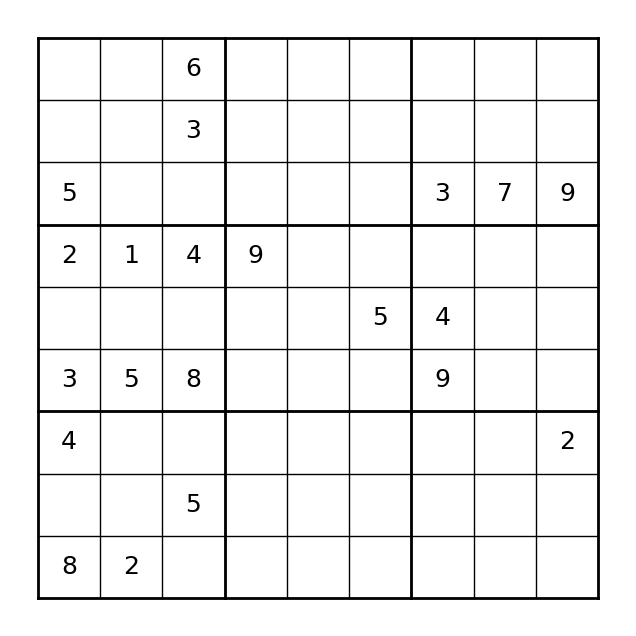

In [88]:
# | echo: false
# | label: fig-sudoku-problem
# | fig-cap: A Sudoku problem

from typing import List
import matplotlib.pyplot as plt
from random import sample
import copy

random.seed(42)

def create_sudoku():
    """create a sudoku puzzle
    source: https://stackoverflow.com/a/56581709
    """
    base  = 3
    side  = base*base

    # pattern for a baseline valid solution
    def pattern(r,c): return (base*(r%base)+r//base+c)%side

    # randomize rows, columns and numbers (of valid base pattern)
    def shuffle(s): return sample(s,len(s)) 
    rBase = range(base) 
    rows  = [ g*base + r for g in shuffle(rBase) for r in shuffle(rBase) ] 
    cols  = [ g*base + c for g in shuffle(rBase) for c in shuffle(rBase) ]
    nums  = shuffle(range(1,base*base+1))

    # produce board using randomized baseline pattern
    board = [ [nums[pattern(r,c)] for c in cols] for r in rows ]
    solution = copy.deepcopy(board)
    
    squares = side*side
    empties = squares * 3//4
    for p in sample(range(squares),empties):
        board[p//side][p%side] = 0

    return board, solution

# define function that draws a sudoku
def draw_sudoku(puzzle: List[List[int]] = None, puzzle_color='k', solution = None):
    fix, ax = plt.subplots(figsize=(8, 8))
    for i in range(0, 10, 3):
        ax.plot([i, i], [0, 9], linewidth=2, color='k')
        ax.plot([0, 9], [i, i], linewidth=2, color='k')
        
    for i in range(1, 9):
        ax.plot([i, i], [0, 9], linewidth=1, color='k')
        ax.plot([0, 9], [i, i], linewidth=1, color='k')
        
    if solution is not None:
        for i in range(9):
            for j in range(9):
                if solution[i][j] != 0:
                    ax.text((j + 0.5), (i + 0.5), str(solution[i][j]), size=18, ha='center', va='center', color='k')

    if puzzle is not None:
        for i in range(9):
            for j in range(9):
                if puzzle[i][j] != 0:
                    ax.text((j + 0.5), (i + 0.5), str(puzzle[i][j]), size=18, ha='center', va='center', color=puzzle_color)
        
    ax.axis('off')
    ax.set_aspect(1.0)
    ax.invert_yaxis()
    plt.show()
    
create_sudoku()

puzzle, solution = create_sudoku()
draw_sudoku(puzzle=puzzle)

To model this problem, we define set $S = (1, 2, 3, 4, 5, 6, 7, 8, 9)$ and use $i, j \in S$ to index the row and column respectively.
In addition, we use $M=\{(i, j, k) | i, j, k \in S\}$ to represent all the known numbers in the grid.

To formulate this problem, we define 9 binary variables for each cell in the 9x9 grid.
Each of the 9 variables corresponds to one of the numbers in set $S$.
Formally, $x_{ijk}$ represents whether the value $k$ shows up in cell $(i, j)$ of the grid.
Note that $i, j, k \in S$.
The mathematical formulation can be stated as below.

\begin{align}
\text{min.} &\quad 0 \label{sudoku-obj} \\
\text{s.t.} &\quad \sum_{j \in S}x_{ijk} = 1, \ \forall i, k \in S \label{sudoku-cons1} \\
&\quad \sum_{i \in S} x_{ijk} = 1, \ \forall j, k \in S \label{sudoku-cons2} \\
&\quad \sum_{k \in S} x_{ijk} = 1, \ \forall i, j \in S \label{sudoku-cons3} \\
&\quad \sum_{(i - 1) \times 3 + 1}^{(i - 1) \times 3 + 3} \sum_{(j - 1) \times 3 + 1}^{(j - 1) \times 3 + 3} x_{ijk} = 1, \ \forall i, j \in \{1, 2, 3\}, k \in S \label{sudoku-cons4}\\
&\quad x_{ijk} = 1, \ \forall (i, j, k) \in M \label{sudoku-cons5}\\
&\quad x_{ijk} \in \{0, 1\}, \ \forall i, j,k \in S
\end{align}

Since no feasible soution is more preferable than another, we use a constant value as the objective function, meaning any feasible soution is an optimal solution to this problem.
Constraints \eqref{sudoku-cons1} require that the number $k \in S$ shows up once and only once in each row of the grid.
Similarly, \eqref{sudoku-cons2} make sure that the number $k \in S$ shows up once and only once in each column of the grid.
For each cell in the grid, only one of the numbers in $S$ can appear, which is guaranteed by constraints \eqref{sudoku-cons3}.
Constraints \eqref{sudoku-cons4} ensure that the numbers in set $S$ show up once and only once in each of the sub-grids.
Constraints \eqref{sudoku-cons5} make sure that the existing numbers in the grid stay the same in the optimal solution.

We can then solve the problem using Google OR-Tools and the code snippet is given below.

In [89]:
import numpy as np
from ortools.linear_solver import pywraplp

# import data
grid_size = 9
subgrid_size = 3
M = [[(1, 3, 6)],
     [(2, 3, 3)],
     [(3, 1, 5), (3, 7, 3), (3, 8, 7), (3, 9, 9)],
     [(4, 1, 2), (4, 2, 1), (4, 3, 4), (4, 4, 0)],
     [(5, 6, 5), (5, 7, 4)],
     [(6, 1, 3), (6, 2, 5), (6, 3, 8), (6, 7, 9)],
     [(7, 1, 4), (7, 9, 2)],
     [(8, 3, 5)],
     [(9, 1, 8), (9, 2, 2)]]

# create solver
solver = pywraplp.Solver.CreateSolver("SCIP")

# # create decision variables
sudoku_vars = np.empty((grid_size, grid_size, grid_size), dtype=object)
for row in range(grid_size):
     for col in range(grid_size):
          for num in range(grid_size):
               sudoku_vars[row][col][num] = solver.Var(0, 
                                   1, 
                                   integer=True, 
                                   name=f"x_{row, col, num}")

# create objective
solver.Minimize(0)

# create constraints
for row in range(grid_size):
     for num in range(grid_size):
          solver.Add(
               solver.Sum([sudoku_vars[row][col][num] 
                              for col in range(grid_size)
                         ]) == 1
                    )

for col in range(grid_size):
     for num in range(grid_size):
          solver.Add(
               solver.Sum([sudoku_vars[row][col][num] 
                              for row in range(grid_size)
                         ]) == 1
                    )
          
for row in range(grid_size):
     for col in range(grid_size):
          solver.Add(
               solver.Sum([sudoku_vars[row][col][num] 
                              for num in range(grid_size)
                         ]) == 1
                    )
          
for row in range(grid_size):
     known_values = M[row]
     for value in known_values:
          row, col, num = value
          solver.Add(
               sudoku_vars[row - 1][col - 1][num - 1] == 1
          )

# solve the problem
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
     sudoku_sol = np.zeros((grid_size, grid_size), dtype=int)
     for row in range(grid_size):
          for col in range(grid_size):
               for num in range(grid_size):
                    if sudoku_vars[row][col][num].solution_value() == 1:
                         sudoku_sol[row][col] = num + 1

@fig-sudoku-sol shows one solution to the example problem.

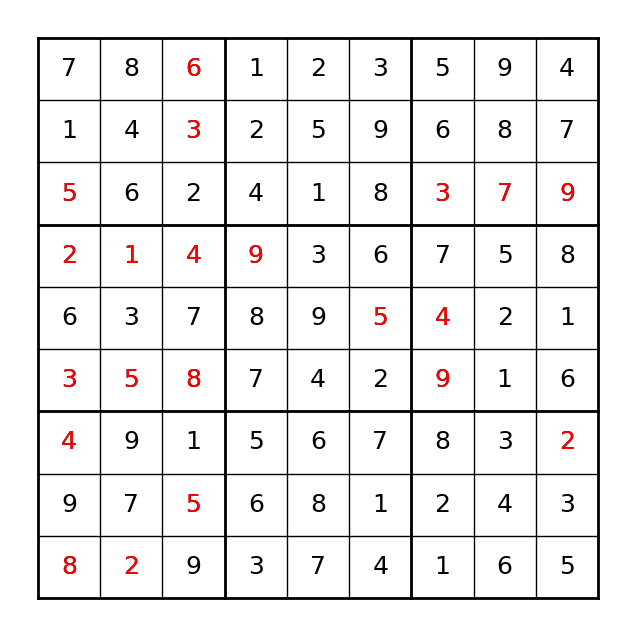

In [91]:
# | echo: false
# | label: fig-sudoku-sol
# | fig-cap: One solution to the Sudoku problem

draw_sudoku(puzzle=puzzle, puzzle_color='r', solution=sudoku_sol)